# Gibbs free energy expressions for IN625 from ternary CALPHAD DB

This notebook extracts relevant thermodynamic functions necessary for the phase-field model of solid-state transformations in additive superalloy 625, represented as a ternary (Cr-Nb-Ni) with γ, δ, μ, and Laves phases competing. The thermodynamic database was prepared by U. Kattner after

    @Article{Du2005,
        Title                    = {A thermodynamic modeling of the Cr–Nb–Ni system },
        Author                   = {Yong Du and Shuhong Liu and Y.A. Chang and Ying Yang},
        Journal                  = {Calphad},
        Year                     = {2005},
        Volume                   = {29},
        Number                   = {2},
        Pages                    = {140 - 148},
        Doi                      = {10.1016/j.calphad.2005.06.001}
    }

This database models the phases of interest as follows:
- γ as $\mathrm{(Cr, Nb, Ni)}$
- δ as $\mathrm{(\mathbf{Nb}, Ni)_1(Cr, Nb, \mathbf{Ni})_3}$
- μ as $\mathrm{Nb_6(Cr, Nb, Ni)_7}$
- Laves as $\mathrm{(\mathbf{Cr}, Nb, Ni)_2(Cr, \mathbf{Nb})_1}$

The phase field model requires Gibbs free energies as functions of system compositions $x_\mathrm{Cr}$, $x_\mathrm{Nb}$, $x_\mathrm{Ni}$. The Calphad database represents these energies as functions of sublattice compositions $y$ in each phase. To avoid solving for internal phase equilibrium at each point in the simulation, approximations have been made to allow the following one-to-one mappings between $x$ and $y$:
- γ: no changes necessary
    * $y_\mathrm{Cr}' = x_\mathrm{Cr}$
    * $y_\mathrm{Nb}' = x_\mathrm{Nb}$
    * $y_\mathrm{Ni}' = x_\mathrm{Ni}$
- δ: eliminate Nb from the second (Ni) sublattice, $\mathrm{(\mathbf{Nb}, Ni)_1(Cr, \mathbf{Ni})_3}$
    * $y_\mathrm{Nb}'  = 4x_\mathrm{Nb}$
    * $y_\mathrm{Ni}'  = 1-4x_\mathrm{Nb}$
    * $y_\mathrm{Cr}'' = \frac{4}{3}x_\mathrm{Cr}$
    * $y_\mathrm{Ni}'' = 1-\frac{4}{3}x_\mathrm{Cr}$
    * Constraints: $x_\mathrm{Nb}\leq\frac{1}{4}$ and $x_\mathrm{Cr}\leq\frac{3}{4}$
- μ: no changes necessary
    * $y_\mathrm{Nb}'  = 1$
    * $y_\mathrm{Cr}'' = x_\mathrm{Cr}$
    * $y_\mathrm{Nb}'' = \frac{13}{7}x_\mathrm{Nb}-\frac{6}{7}$
    * $y_\mathrm{Ni}'' = x_\mathrm{Ni}$
    * Constraints: $x_\mathrm{Cr}\leq\frac{7}{13}$ and $x_\mathrm{Nb}\geq\frac{6}{13}$ and $x_\mathrm{Ni}\leq\frac{7}{13}$
- Laves: eliminate Nb from the first (Cr) sublattice, $\mathrm{(\mathbf{Cr}, Ni)_2(Cr, \mathbf{Nb})_1}$
    * $y_\mathrm{Cr}' = 1-\frac{3}{2}x_\mathrm{Ni}$ with $0\leq x_\mathrm{Ni}\leq\frac{2}{3}$
    * $y_\mathrm{Ni}' = \frac{3}{2}x_\mathrm{Ni}$ with $0\leq x_\mathrm{Ni}\leq\frac{2}{3}$
    * $y_\mathrm{Cr}'' = 1-3x_\mathrm{Nb}$   with $0\leq x_\mathrm{Nb}\leq\frac{1}{3}$
    * $y_\mathrm{Nb}'' = 3x_\mathrm{Nb}$   with $0\leq x_\mathrm{Nb}\leq\frac{1}{3}$

In [247]:
%matplotlib inline
# Numerical libraries
import numpy as np
from scipy.optimize import fsolve
from sympy.utilities.lambdify import lambdify
from scipy.spatial import ConvexHull

# Runtime / parallel libraries
import time, warnings
from itertools import chain
from multiprocessing import Pool

# Thermodynamics and computer-algebra libraries
from pycalphad import Database, calculate, Model
from sympy.utilities.codegen import codegen
from sympy.parsing.sympy_parser import parse_expr
from sympy import And, diff, Ge, Gt, Le, Lt, Piecewise, simplify, symbols, sympify

# Visualization libraries
import matplotlib.pylab as plt
from ipywidgets import FloatProgress
from IPython.display import display

# Constants
epsilon = 1e-8 # tolerance for comparing floating-point numbers to zero
temp = 870.0 + 273.15 # 1143 Kelvin
#temp = 1050.0 + 273.15 # Kelvin

RT = 8.3144598*temp # J/mol/K

In [248]:
# Let's avoid integer arithmetic in fractions.
fr13by7 = 13.0/7
fr13by3 = 13.0/3
fr13by4 = 13.0/4
fr6by7 = 6.0/7
fr6by13 = 6.0/13
fr7by13 = 7.0/13
fr3by4 = 3.0/4
fr3by2 = 3.0/2
fr4by3 = 4.0/3
fr2by3 = 2.0/3
fr1by3 = 1.0/3
fr1by2 = 1.0/2
rt3by2 = np.sqrt(3.0)/2

In [249]:
#tdb = Database('mc_ni_v2.033.tdb')
#tdb = Database('monbni-simple.tdb')
#tdb = Database('Thermotech_Cr-Nb-Ni_FCC-delta-mu-BCC.tdb')
#tdb = Database('Thermotech_Cr-Nb-Ni_FCC-delta-mu-BCC_simple.tdb')
tdb = Database('Du_Cr-Nb-Ni_simple.tdb')

In [250]:
# phases = ['FCC_A1', 'D0A_NBNI3', 'D85_NI7NB6', 'BCC_A2', 'LIQUID']
phases = ['FCC_A1', 'D0A_NBNI3', 'D85_NI7NB6', 'C14_LAVES', 'C15_LAVES', 'BCC_A2']
elements = ['CR', 'NB', 'NI']

## Export Gibbs functions using SymPy

In [251]:
c_gamma = list(set([i for c in tdb.phases['FCC_A1'].constituents for i in c]))
m_gamma = Model(tdb, c_gamma, 'FCC_A1')
g_gamma = parse_expr(str(m_gamma.ast))

In [252]:
c_delta = list(set([i for c in tdb.phases['D0A_NBNI3'].constituents for i in c]))
m_delta = Model(tdb, c_delta, 'D0A_NBNI3')
g_delta = parse_expr(str(m_delta.ast))

In [253]:
c_mu = list(set([i for c in tdb.phases['D85_NI7NB6'].constituents for i in c]))
m_mu = Model(tdb, c_mu, 'D85_NI7NB6')
g_mu = parse_expr(str(m_mu.ast))

In [254]:
c_lavesHT = list(set([i for c in tdb.phases['C14_LAVES'].constituents for i in c]))
m_lavesHT = Model(tdb, c_lavesHT, 'C14_LAVES')
g_lavesHT = parse_expr(str(m_lavesHT.ast))

In [255]:
c_lavesLT = list(set([i for c in tdb.phases['C15_LAVES'].constituents for i in c]))
m_lavesLT = Model(tdb, c_lavesLT, 'C15_LAVES')
g_lavesLT = parse_expr(str(m_lavesLT.ast))

In [256]:
c_bcc = list(set([i for c in tdb.phases['BCC_A2'].constituents for i in c]))
m_bcc = Model(tdb, c_bcc, 'BCC_A2')
g_bcc = parse_expr(str(m_bcc.ast))

## Convert sublattice to phase composition (y to x)

In [257]:
# Declare sublattice variables used in Pycalphad expressions
# Gamma
FCC_A10CR, FCC_A10NB, FCC_A10NI, FCC_A11VA = symbols('FCC_A10CR FCC_A10NB FCC_A10NI FCC_A11VA')
# Delta
D0A_NBNI30NI, D0A_NBNI30NB, D0A_NBNI31CR, D0A_NBNI31NI = symbols('D0A_NBNI30NI D0A_NBNI30NB D0A_NBNI31CR D0A_NBNI31NI')
# Mu
D85_NI7NB60NB, D85_NI7NB61CR, D85_NI7NB61NB, D85_NI7NB61NI = symbols('D85_NI7NB60NB D85_NI7NB61CR D85_NI7NB61NB D85_NI7NB61NI')
# Laves
C14_LAVES0CR, C14_LAVES0NI, C14_LAVES1CR, C14_LAVES1NB = symbols('C14_LAVES0CR C14_LAVES0NI C14_LAVES1CR C14_LAVES1NB') 
C15_LAVES0CR, C15_LAVES0NI, C15_LAVES1CR, C15_LAVES1NB = symbols('C15_LAVES0CR C15_LAVES0NI C15_LAVES1CR C15_LAVES1NB') 
# BCC
BCC_A20CR, BCC_A20NB, BCC_A20NI, BCC_A21VA = symbols('BCC_A20CR BCC_A20NB BCC_A20NI BCC_A21VA')
# Temperature
T = symbols('T')

# Declare system variables for target expressions
GAMMA_XCR, GAMMA_XNB, GAMMA_XNI = symbols('GAMMA_XCR GAMMA_XNB GAMMA_XNI')
DELTA_XCR, DELTA_XNB, DELTA_XNI = symbols('DELTA_XCR DELTA_XNB DELTA_XNI')
MU_XCR, MU_XNB, MU_XNI = symbols('MU_XCR MU_XNB MU_XNI')
LAVES_XCR, LAVES_XNB, LAVES_XNI = symbols('LAVES_XCR LAVES_XNB LAVES_XNI')
BCC_XCR, BCC_XNB, BCC_XNI = symbols('BCC_XCR BCC_XNB BCC_XNI')

In [258]:
# Make substitutions

g_gamma = g_gamma.subs({FCC_A10CR: GAMMA_XCR,
                        FCC_A10NB: GAMMA_XNB,
                        FCC_A10NI: GAMMA_XNI,
                        FCC_A11VA: 1.0,
                        T: temp})

g_delta = Piecewise((g_delta.subs({
                     D0A_NBNI30NB: 4.0*DELTA_XNB,
                     D0A_NBNI30NI: 1.0 - 4.0*DELTA_XNB,
                     D0A_NBNI31CR: fr4by3 * DELTA_XCR,
                     D0A_NBNI31NI: 1.0 - fr4by3 * DELTA_XCR,
                     T: temp}), \
                     And(Le(DELTA_XCR, 0.75), Le(DELTA_XNB, 0.25))),
                    (0, True)) # Delta depends only on xcr and xnb, not xni

g_mu = Piecewise((g_mu.subs({
                  D85_NI7NB60NB: 1.0,
                  D85_NI7NB61CR: fr13by7*MU_XCR,
                  D85_NI7NB61NB: fr13by7*MU_XNB - fr6by7,
                  D85_NI7NB61NI: fr13by7*MU_XNI,
                  T: temp}), \
                  And(Le(MU_XCR+MU_XNI, fr7by13), Ge(MU_XNB, fr6by13))),
                (0, True)) # Mu depends only on xcr and xni, not xnb

g_lavesHT = Piecewise((g_lavesHT.subs({
                  C14_LAVES0CR: 1.0 - fr3by2*LAVES_XNI,
                  C14_LAVES0NI: fr3by2 * LAVES_XNI,
                  C14_LAVES1CR: 1.0 - 3.0*LAVES_XNB,
                  C14_LAVES1NB: 3.0 * LAVES_XNB,
                  T: temp}), \
                  And(Lt(LAVES_XNI, fr2by3), Lt(LAVES_XNB, fr1by3))),
                (0, True)) # Laves depends only on xnb and xni, not xcr

g_lavesLT = Piecewise((g_lavesLT.subs({
                  C15_LAVES0CR: 1.0 - fr3by2*LAVES_XNI,
                  C15_LAVES0NI: fr3by2 * LAVES_XNI,
                  C15_LAVES1CR: 1.0 - 3.0*LAVES_XNB,
                  C15_LAVES1NB: 3.0 * LAVES_XNB,
                  T: temp}), \
                  And(Lt(LAVES_XNI, fr2by3), Lt(LAVES_XNB, fr1by3))),
                (0, True))

g_bcc = g_bcc.subs({BCC_A20CR: BCC_XCR,
                    BCC_A20NB: BCC_XNB,
                    BCC_A20NI: BCC_XNI,
                    BCC_A21VA: 1.0,
                    T: temp})

In [259]:
# Generate numerically efficient system-composition expressions
# Gg = lambdify((GAMMA_XCR, GAMMA_XNB, GAMMA_XNI), g_gamma, modules='numpy')
# Gd = lambdify((DELTA_XCR, DELTA_XNB, DELTA_XNI), g_delta, modules='numpy')
# Gu = lambdify((MU_XCR, MU_XNB, MU_XNI), g_mu, modules='numpy')
# Gh = lambdify((LAVES_XCR, LAVES_XNB, LAVES_XNI), g_lavesHT, modules='numpy')
# Gl = lambdify((LAVES_XCR, LAVES_XNB, LAVES_XNI), g_lavesLT, modules='numpy')
# Gb = lambdify((BCC_XCR, BCC_XNB, BCC_XNI), g_bcc, modules='numpy')
Gg = lambdify((GAMMA_XCR, GAMMA_XNB, GAMMA_XNI), g_gamma, modules='numpy')
Gd = lambdify((DELTA_XCR, DELTA_XNB), g_delta, modules='numpy')
Gu = lambdify((MU_XCR, MU_XNB, MU_XNI), g_mu, modules='numpy')
Gh = lambdify((LAVES_XNB, LAVES_XNI), g_lavesHT, modules='numpy')
Gl = lambdify((LAVES_XNB, LAVES_XNI), g_lavesLT, modules='numpy')
Gb = lambdify((BCC_XCR, BCC_XNB, BCC_XNI), g_bcc, modules='numpy')

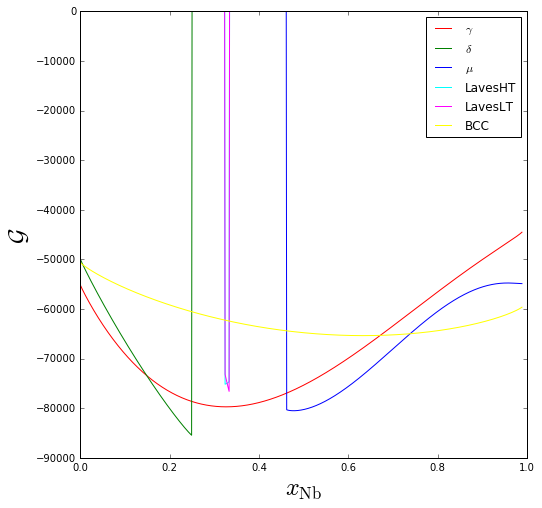

In [260]:
labels = [r'$\gamma$', r'$\delta$', r'$\mu$', 'LavesHT', 'LavesLT', 'BCC']
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']

# plot Gibbs energy curves for fixed x_Cr = 1% to check mu stability
if True:
    xcr = 0.01
    X = []
    G = [[], [], [], [], [], []]

    for xnb in np.linspace(epsilon,1,1001):
        xni = 1-xcr-xnb
        if xni>0:
            X.append(xnb)
            G[0].append(Gg(xcr,xnb,xni))
            G[1].append(Gd(xcr,xnb))
            G[2].append(Gu(xcr,xnb,xni))
            G[3].append(Gh(xnb,xni))
            G[4].append(Gl(xnb,xni))
            G[5].append(Gb(xcr,xnb,xni))
#             G[0].append(Gg(xcr,xnb,xni))
#             G[1].append(Gd(xcr,xnb,xni))
#             G[2].append(Gu(xcr,xnb,xni))
#             G[3].append(Gh(xcr,xnb,xni))
#             G[4].append(Gl(xcr,xnb,xni))
#             G[5].append(Gb(xcr,xnb,xni))

    plt.figure(figsize=(8, 8))
    plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    #plt.ylim([-100000, -40000])
    for i in range(len(labels)):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

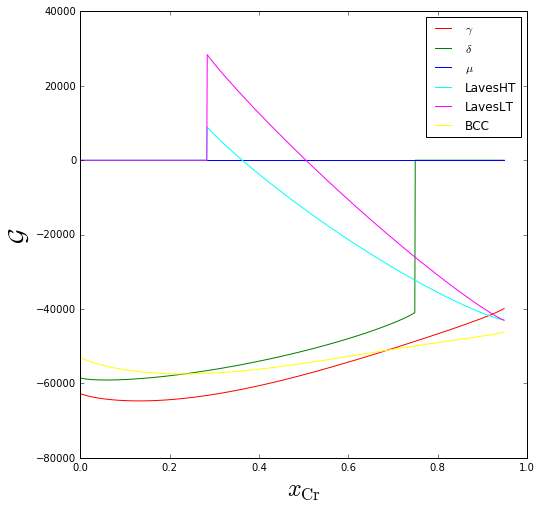

In [261]:
# plot Gibbs energy curves for fixed x_Nb = 5% to check delta stability
if True:
    xnb = 0.05
    X = []
    G = [[],[],[],[], [], []]

    for xcr in np.linspace(epsilon,1,1001):
        xni = 1-xcr-xnb
        if xni>0:
            X.append(xcr)
            G[0].append(Gg(xcr,xnb,xni))
            G[1].append(Gd(xcr,xnb))
            G[2].append(Gu(xcr,xnb,xni))
            G[3].append(Gh(xnb,xni))
            G[4].append(Gl(xnb,xni))
            G[5].append(Gb(xcr,xnb,xni))
#             G[0].append(Gg(xcr,xnb,xni))
#             G[1].append(Gd(xcr,xnb,xni))
#             G[2].append(Gu(xcr,xnb,xni))
#             G[3].append(Gh(xcr,xnb,xni))
#             G[4].append(Gl(xcr,xnb,xni))
#             G[5].append(Gb(xcr,xnb,xni))

    plt.figure(figsize=(8, 8))
    plt.xlabel(r'$x_\mathrm{Cr}$', fontsize=24)
    plt.ylabel(r'$\mathcal{G}$', fontsize=24)
    #plt.ylim([-100000, -40000])
    for i in range(len(labels)):
        plt.plot(X, G[i], color=colors[i], label=labels[i])
    plt.legend(loc='best')

# Generate a phase diagram
Using scipy.spatial.ConvexHull, an interface to qhull. This method cannot provide phase fractions, chemical potentials, etc., but will quickly produce the correct diagram from the given Gibbs energies.

In [68]:
# triangle bounding the Gibbs simplex
XS = [0.0, 1.0, 0.5, 0.0]
YS = [0.0, 0.0,rt3by2, 0.0]
# triangle bounding three-phase coexistence
XT = [0.25, 0.4875+0.025/2,0.5375+0.4625/2, 0.25]
YT = [0.0,  0.025*rt3by2, 0.4625*rt3by2, 0.0]
# Tick marks along simplex edges
Xtick = []
Ytick = []
for i in range(20):
    # Cr-Ni edge
    xcr = 0.05*i
    xni = 1.0 - xcr
    Xtick.append(xcr/2 - 0.002)
    Ytick.append(rt3by2*xcr)
    # Cr-Nb edge
    xcr = 0.05*i
    xnb = 1.0 - xcr
    Xtick.append(xnb + xcr/2 + 0.002)
    Ytick.append(rt3by2*xcr)

In [69]:
def computeKernelExclusive(n):
    a = n / density # index along x-axis
    b = n % density # index along y-axis

    xnb = epsilon + 1.0*a / (density-1)
    xcr = epsilon + 1.0*b / (density-1)
    xni = 1.0 - xcr - xnb

    result = [0]*9
    
    if xni>0:
        result[0] = xcr
        result[1] = xnb
        result[2] = xni
        result[3] = Gg(xcr,xnb,xni)
        result[4] = Gd(xcr,xnb)
        result[5] = Gu(xcr,xnb,xni)
        result[6] = Gh(xnb,xni)
        result[7] = Gl(xnb,xni)
        result[8] = Gb(xcr,xnb,xni)
#         result[3] = Gg(xcr,xnb,xni)
#         result[4] = Gd(xcr,xnb,xni)
#         result[5] = Gu(xcr,xnb,xni)
#         result[6] = Gh(xcr,xnb,xni)
#         result[7] = Gl(xcr,xnb,xni)
#         result[8] = Gb(xcr,xnb,xni)
    
    return result

In [70]:
density = 501
allCr = []
allNb = []
allG = []
allID = []
points = []
phases = []

if __name__ == '__main__':
    starttime = time.time() # not exact, but multiprocessing makes time.clock() read from different cores

    bar = FloatProgress(min=0,max=density**2)
    display(bar)

    pool = Pool(12)

    i = 0
    for result in pool.imap(computeKernelExclusive, range(density**2)):
        xcr, xnb, xni, fg, fd, fu, fh, fl, fb = result
        f = (fg, fd, fu, fh, fl, fb)

        # Accumulate (x, y, G) points for each phase
        if (fd**2 + fu**2 + fh**2 + fl**2) > epsilon:
            for n in range(len(f)):
                allCr.append(rt3by2*xcr)
                allNb.append(xnb+xcr/2)
                allG.append(f[n])
                allID.append(n)
        i += 1
        bar.value = i

    pool.close()
    pool.join()
    
    points = np.array([allCr, allNb, allG]).T
    
    hull = ConvexHull(points)
    
    runtime = time.time() - starttime
    print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

0h:3m:7s elapsed


In [71]:
starttime = time.time()

In [72]:
# Prepare arrays for plotting
X = [[],[],[],[], [], []]
Y = [[],[],[],[], [], []]
tielines = []

for simplex in hull.simplices:
    for i in simplex:
        X[allID[i]].append(allNb[i])
        Y[allID[i]].append(allCr[i])
        for j in simplex:
            if allID[i] != allID[j]:
                tielines.append([[allNb[i], allNb[j]],
                                 [allCr[i], allCr[j]]])

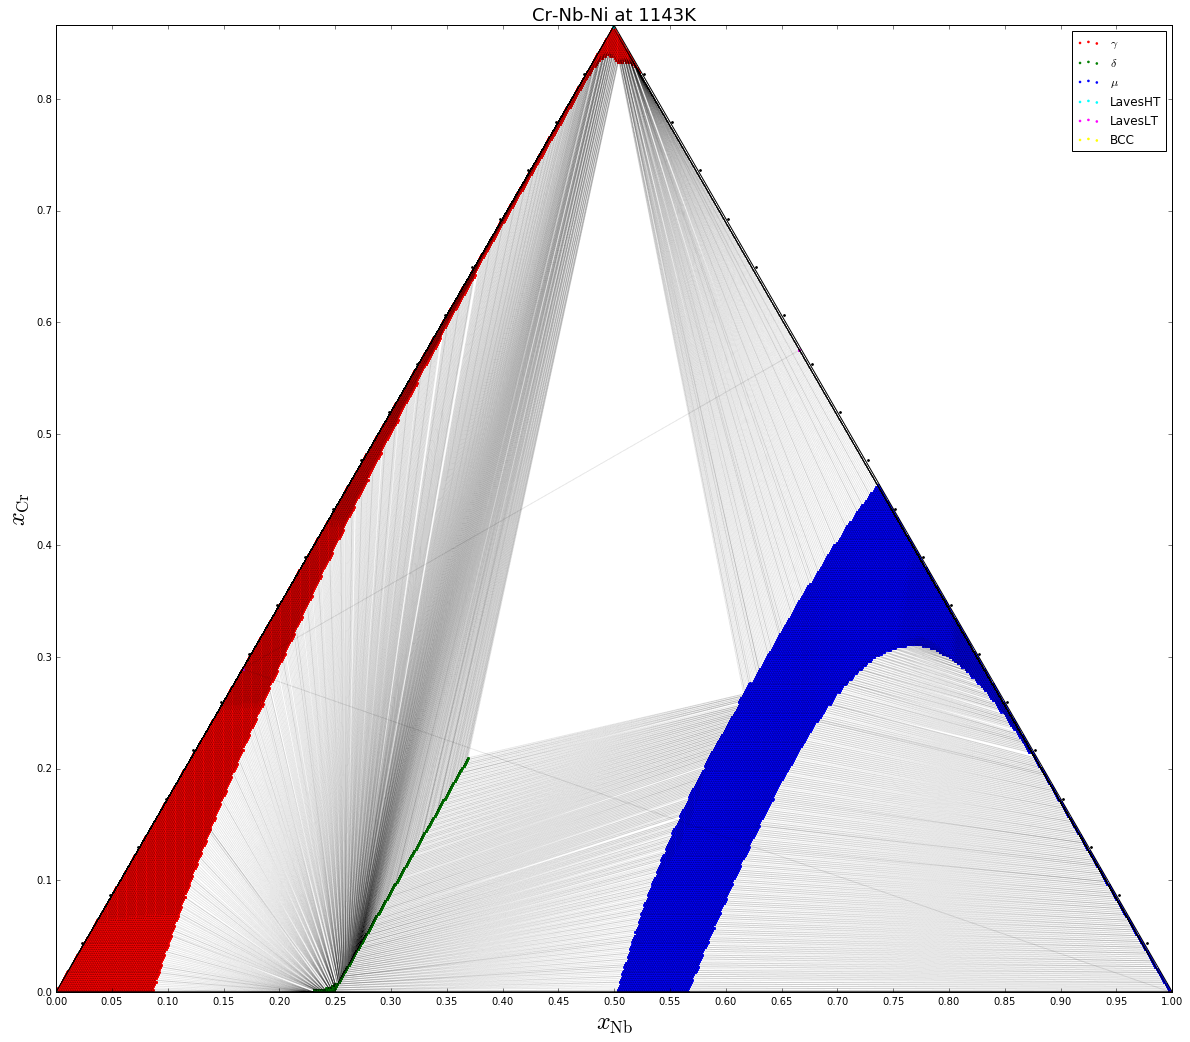

In [73]:
# Plot phase diagram
pltsize = 20
plt.figure(figsize=(pltsize, rt3by2*pltsize))
plt.title("Cr-Nb-Ni at %.0fK"%temp, fontsize=18)
plt.xlim([0,1])
plt.ylim([0,rt3by2])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Cr}$', fontsize=24)
plt.plot(XS, YS, '-k')
n = 0
for tie in tielines:
    plt.plot(tie[0], tie[1], '-k', alpha=0.025)
for i in range(len(labels)):
    plt.scatter(X[i], Y[i], color=colors[i], s=2.5, label=labels[i])
plt.xticks(np.linspace(0, 1, 21))
plt.scatter(Xtick, Ytick, color='black', s=3)
plt.legend(loc='best')
plt.show()

In [74]:
runtime = time.time() - starttime
print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

0h:8m:39s elapsed


## Interfacial Energy
This is a naïve attempt to determine an appropriate interfacial energy for $\mu$-phase by finding the balancing point of metastable equilibrium between $\gamma$ and $\mu$.

In [350]:
sigma_del = 1.01 # J/m^2
sigma_mu = sigma_del #/ 10 # J/m^2
sigma_lav = sigma_del #/ 10 # J/m^2
sigma_gprime = sigma_del / 20 # J / m^2: absolute minimum interfacial energy!
#if sigma_gprime > sigma_mu or sigma_gprime > sigma_lav:
#    # complain bitterly and at length about breaking physics    

rmax = 1.0e-8  # m
rmin = 1.0e-16 # m
Vm = 1.0e-5 # m**3/mol

radius = 7.0e-9

In [351]:
def computeKernelInterfacial(n):
    a = n / density # index along x-axis
    b = n % density # index along y-axis

    xnb = epsilon + 1.0*a / (density-1)
    xcr = epsilon + 1.0*b / (density-1)
    xni = 1.0 - xcr - xnb

    result = [0]*8
    
    if xni>0:
        result[0] = xcr
        result[1] = xnb
        result[2] = xni
        result[3] = Gg(xcr,xnb,xni)
        result[4] = Gd(xcr,xnb)     + 2.0 * Vm * sigma_del / radius
        result[5] = Gu(xcr,xnb,xni) + 2.0 * Vm * sigma_mu  / radius
        result[6] = Gh(xnb,xni)     + 2.0 * Vm * sigma_lav / radius
        result[7] = Gl(xnb,xni)     + 2.0 * Vm * sigma_lav / radius
        #result[8] = Gb(xcr,xnb,xni) # Exclude BCC

    return result

In [352]:
density = 201
allCr = []
allNb = []
allG = []
allID = []
points = []
phases = []

if __name__ == '__main__':
    starttime = time.time() # not exact, but multiprocessing makes time.clock() read from different cores

    bar = FloatProgress(min=0, max=density**2)
    display(bar)

    pool = Pool(12)

    i = 0
    for result in pool.imap(computeKernelInterfacial, range(density**2)):
        # Excluding BCC
        xcr, xnb, xni, fg, fd, fu, fh, fl = result
        f = (fg, fd, fu, fh, fl)

        # Accumulate (x, y, G) points for each phase
        if (fd**2 + fu**2 + fh**2 + fl**2) > epsilon:
            for n in range(len(f)):
                allCr.append(rt3by2*xcr)
                allNb.append(xnb+xcr/2)
                allG.append(f[n])
                allID.append(n)
        i += 1
        bar.value = i

    pool.close()
    pool.join()
    
    points = np.array([allCr, allNb, allG]).T
    
    hull = ConvexHull(points)
    
    runtime = time.time() - starttime
    print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

0h:0m:31s elapsed


In [353]:
starttime = time.time()

In [354]:
# Prepare arrays for plotting
X = [[],[],[],[], [], []]
Y = [[],[],[],[], [], []]
tielines = []

for simplex in hull.simplices:
    for i in simplex:
        X[allID[i]].append(allNb[i])
        Y[allID[i]].append(allCr[i])
        for j in simplex:
            if allID[i] != allID[j]:
                tielines.append([[allNb[i], allNb[j]],
                                 [allCr[i], allCr[j]]])

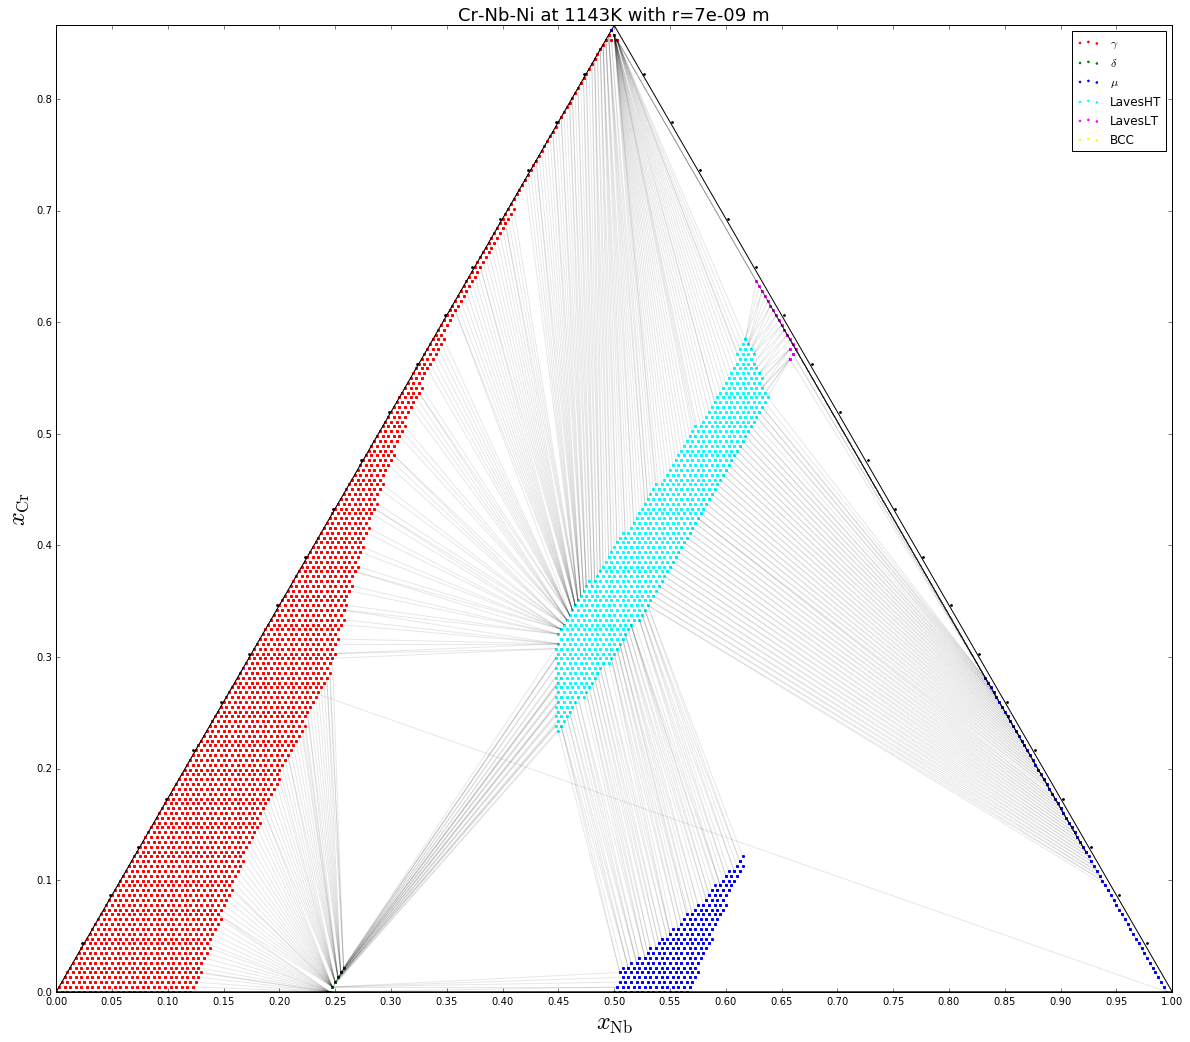

In [355]:
# Plot phase diagram
pltsize = 20
plt.figure(figsize=(pltsize, rt3by2*pltsize))
plt.title("Cr-Nb-Ni at %.0fK with r=%.0e m"%(temp, radius), fontsize=18)
plt.xlim([0,1])
plt.ylim([0,rt3by2])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Cr}$', fontsize=24)
plt.plot(XS, YS, '-k')
for tie in tielines:
    plt.plot(tie[0], tie[1], '-k', alpha=0.025)
for i in range(len(labels)):
    plt.scatter(X[i], Y[i], color=colors[i], s=2.5, label=labels[i])
plt.xticks(np.linspace(0, 1, 21))
plt.scatter(Xtick, Ytick, color='black', s=3)
plt.legend(loc='best')
plt.show()

In [356]:
runtime = time.time() - starttime
print "%ih:%im:%is elapsed" % (int(runtime/3600), int(runtime/60)%60, int(runtime)%60)

0h:0m:9s elapsed


## Scan over precipitate sizes
For the initial condition, need to know how big (or small) to make each precipitate.

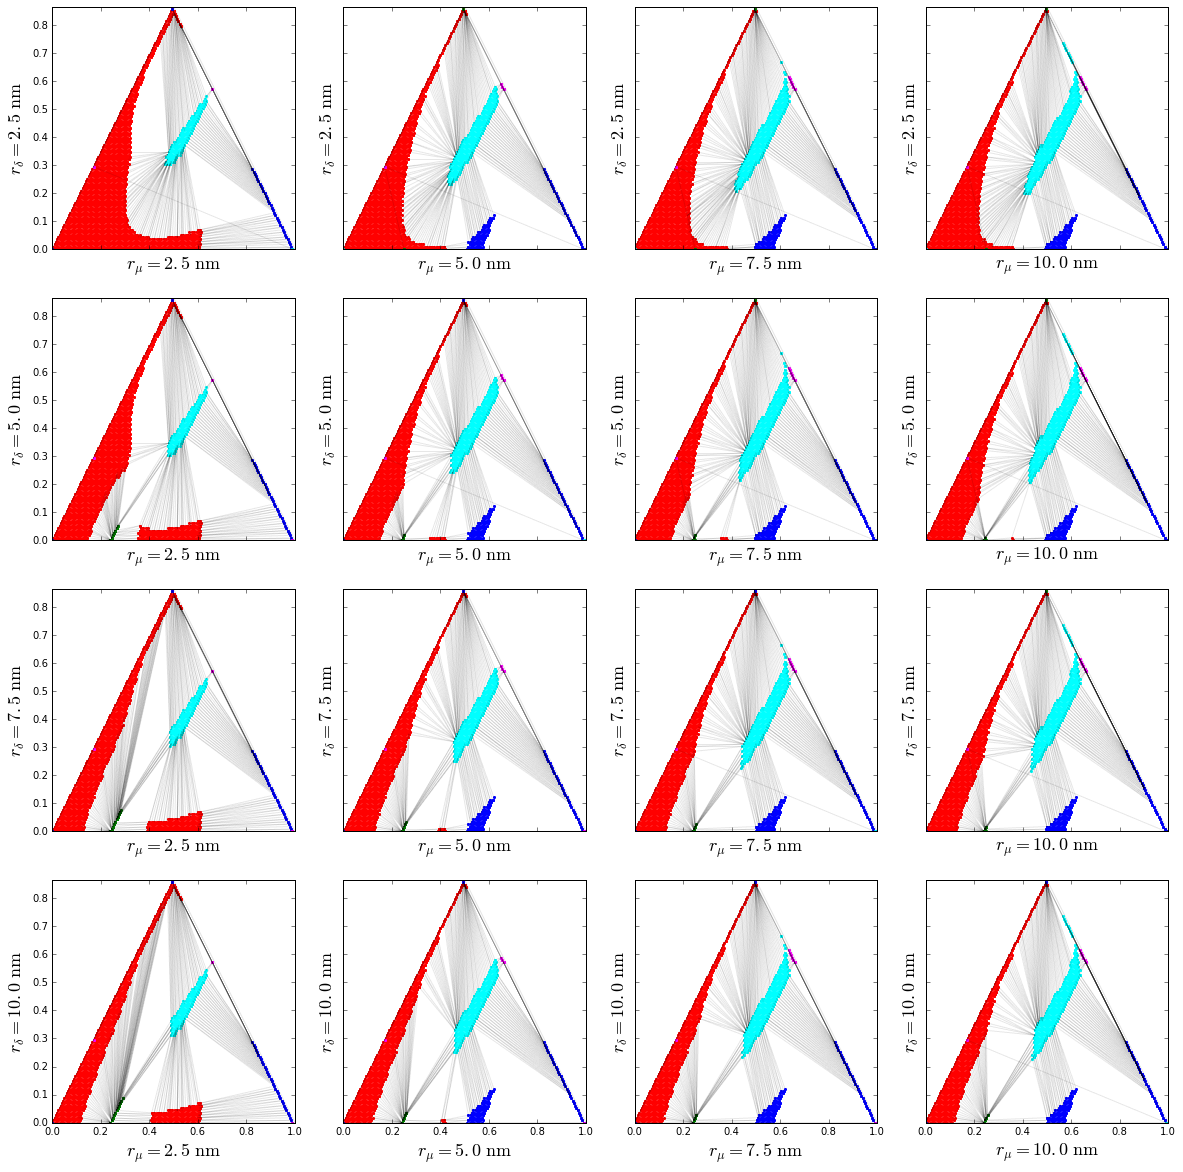

In [382]:
density = 101
lattice = 4
r0 = 2.5e-9

def computeKernelLattice(n):
    a = n / density # index along x-axis
    b = n % density # index along y-axis

    xnb = epsilon + 1.0*a / (density-1)
    xcr = epsilon + 1.0*b / (density-1)
    xni = 1.0 - xcr - xnb

    result = [0]*8
    
    if xni>0:
        result[0] = xcr
        result[1] = xnb
        result[2] = xni
        result[3] = Gg(xcr,xnb,xni)
        result[4] = Gd(xcr,xnb)     + 2.0 * Vm * sigma / rA
        result[5] = Gu(xcr,xnb,xni) + 2.0 * Vm * sigma / rB
        result[6] = Gh(xnb,xni)     + 2.0 * Vm * sigma / rB
        result[7] = Gl(xnb,xni)     + 2.0 * Vm * sigma / rB

    return result

fig, axs = plt.subplots(lattice, lattice, sharex=True, sharey=True, figsize=(pltsize, pltsize))

bar = FloatProgress(min=0, max=lattice**2)
display(bar)

for p in range(lattice):
    for q in range(lattice):
        rA = r0 * (p+1) # m
        rB = r0 * (q+1) # m
        sigma = 1.01 # J/m^2
        
        allCr = []
        allNb = []
        allG = []
        allID = []
        points = []
        phases = []

        pool = Pool(12)
        for result in pool.imap(computeKernelLattice, range(density**2)):
            xcr, xnb, xni, fg, fd, fu, fh, fl = result
            f = (fg, fd, fu, fh, fl)

            # Accumulate (x, y, G) points for each phase
            if (fd**2 + fu**2 + fh**2 + fl**2) > epsilon:
                for n in range(len(f)):
                    allCr.append(rt3by2*xcr)
                    allNb.append(xnb+xcr/2)
                    allG.append(f[n])
                    allID.append(n)
        pool.close()
        pool.join()

        points = np.array([allCr, allNb, allG]).T

        hull = ConvexHull(points)

        X = [[],[],[],[], [], []]
        Y = [[],[],[],[], [], []]
        tielines = []

        for simplex in hull.simplices:
            for i in simplex:
                X[allID[i]].append(allNb[i])
                Y[allID[i]].append(allCr[i])
                for j in simplex:
                    if allID[i] != allID[j]:
                        tielines.append([[allNb[i], allNb[j]],
                                         [allCr[i], allCr[j]]])
        
        axs[p,q].set_xlim([0,1])
        axs[p,q].set_ylim([0,rt3by2])
        axs[p,q].set_xlabel(r'$r_\mu=%.1f\ \mathrm{nm}$'%(2.5*(q+1)), fontsize=(18*4)/lattice)
        axs[p,q].set_ylabel(r'$r_\delta=%.1f\ \mathrm{nm}$'%(2.5*(p+1)), fontsize=(18*4)/lattice)
        axs[p,q].plot(XS, YS, '-k', alpha=0.1)
        for tie in tielines:
            axs[p,q].plot(tie[0], tie[1], '-k', alpha=0.025)
        for i in range(len(labels)):
            axs[p,q].scatter(X[i], Y[i], color=colors[i], s=2.5)
        bar.value = (p*lattice) + q + 1

plt.show()

## Export C code
If the phase diagram above looks "right," proceed to code generation. 

In [106]:
# First derivatives
dGgam_dxCr = diff(g_gamma, GAMMA_XCR)
dGgam_dxNb = diff(g_gamma, GAMMA_XNB)

dGdel_dxCr = diff(g_delta, DELTA_XCR)
dGdel_dxNb = diff(g_delta, DELTA_XNB)

dGmu_dxCr = diff(g_mu, MU_XCR)
dGmu_dxNb = diff(g_mu, MU_XNB)

dGlavH_dxCr = diff(g_lavesHT, LAVES_XCR)
dGlavH_dxNb = diff(g_lavesHT, LAVES_XNB)
dGlavL_dxCr = diff(g_lavesLT, LAVES_XCR)
dGlavL_dxNb = diff(g_lavesLT, LAVES_XNB)

dGbcc_dxCr = diff(g_bcc, BCC_XCR)
dGbcc_dxNb = diff(g_bcc, BCC_XNB)

# Second derivatives
d2Ggam_dxCrCr = diff(dGgam_dxCr, GAMMA_XCR)
d2Ggam_dxCrNb = diff(dGgam_dxCr, GAMMA_XNB)
d2Ggam_dxNbCr = diff(dGgam_dxNb, GAMMA_XCR)
d2Ggam_dxNbNb = diff(dGgam_dxNb, GAMMA_XNB)

d2Gdel_dxCrCr = diff(dGdel_dxCr, DELTA_XCR)
d2Gdel_dxCrNb = diff(dGdel_dxCr, DELTA_XNB)
d2Gdel_dxNbCr = diff(dGdel_dxNb, DELTA_XCR)
d2Gdel_dxNbNb = diff(dGdel_dxNb, DELTA_XNB)

d2Gmu_dxCrCr = diff(dGmu_dxCr, MU_XCR)
d2Gmu_dxCrNb = diff(dGmu_dxCr, MU_XNB)
d2Gmu_dxNbCr = diff(dGmu_dxNb, MU_XCR)
d2Gmu_dxNbNb = diff(dGmu_dxNb, MU_XNB)

d2GlavH_dxCrCr = diff(dGlavH_dxCr, LAVES_XCR)
d2GlavH_dxCrNb = diff(dGlavH_dxCr, LAVES_XNB)
d2GlavH_dxNbCr = diff(dGlavH_dxNb, LAVES_XCR)
d2GlavH_dxNbNb = diff(dGlavH_dxNb, LAVES_XNB)

d2GlavL_dxCrCr = diff(dGlavL_dxCr, LAVES_XCR)
d2GlavL_dxCrNb = diff(dGlavL_dxCr, LAVES_XNB)
d2GlavL_dxNbCr = diff(dGlavL_dxNb, LAVES_XCR)
d2GlavL_dxNbNb = diff(dGlavL_dxNb, LAVES_XNB)

d2Gbcc_dxCrCr = diff(dGbcc_dxCr, BCC_XCR)
d2Gbcc_dxCrNb = diff(dGbcc_dxCr, BCC_XNB)
d2Gbcc_dxNbCr = diff(dGbcc_dxNb, BCC_XCR)
d2Gbcc_dxNbNb = diff(dGbcc_dxNb, BCC_XNB)


In [107]:
# Write Gibbs energy functions to disk, for direct use in phase-field code
codegen([# Gibbs energies
         ('g_gam',g_gamma), ('g_mu',g_mu), ('g_lav',g_lavesHT), ('g_lavLT',g_lavesLT), ('g_del',g_delta), ('g_bcc',g_bcc),
         # First derivatives
         ('dg_gam_dxCr',dGgam_dxCr), ('dg_gam_dxNb',dGgam_dxNb),
         ('dg_del_dxCr',dGdel_dxCr), ('dg_del_dxNb',dGdel_dxNb),
         ('dg_mu_dxCr',dGmu_dxCr), ('dg_mu_dxNb',dGmu_dxNb),
         ('dg_lav_dxCr',dGlavH_dxCr), ('dg_lav_dxNb',dGlavH_dxNb),
         ('dg_lavLT_dxCr',dGlavL_dxCr), ('dg_lavLT_dxNb',dGlavL_dxNb),
         ('dg_bcc_dxCr',dGbcc_dxCr), ('dg_bcc_dxNb',dGbcc_dxNb),
         # Second derivatives
         ('d2g_gam_dxCrCr',d2Ggam_dxCrCr), ('d2g_gam_dxCrNb',d2Ggam_dxCrNb),
         ('d2g_gam_dxNbNb',d2Ggam_dxNbNb), ('d2g_gam_dxNbCr',d2Ggam_dxNbCr),
         ('d2g_del_dxCrCr',d2Gdel_dxCrCr), ('d2g_del_dxCrNb',d2Gdel_dxCrNb),
         ('d2g_del_dxNbNb',d2Gdel_dxNbNb), ('d2g_del_dxNbCr',d2Gdel_dxNbCr),
         ('d2g_mu_dxCrCr', d2Gmu_dxCrCr), ('d2g_mu_dxCrNb', d2Gmu_dxCrNb),
         ('d2g_mu_dxNbNb', d2Gmu_dxNbNb), ('d2g_mu_dxNbCr', d2Gmu_dxNbCr),
         ('d2g_lav_dxCrCr', d2GlavH_dxCrCr), ('d2g_lav_dxCrNb', d2GlavH_dxCrNb),
         ('d2g_lav_dxNbNb', d2GlavH_dxNbNb), ('d2g_lav_dxNbCr', d2GlavH_dxNbCr),
         ('d2g_lavLT_dxCrCr', d2GlavL_dxCrCr), ('d2g_lavLT_dxCrNb', d2GlavL_dxCrNb),
         ('d2g_lavLT_dxNbNb', d2GlavL_dxNbNb), ('d2g_lavLT_dxNbCr', d2GlavL_dxNbCr),
         ('d2g_bcc_dxCrCr',d2Gbcc_dxCrCr), ('d2g_bcc_dxCrNb',d2Gbcc_dxCrNb),
        ('d2g_bcc_dxNbNb',d2Gbcc_dxNbNb), ('d2g_bcc_dxNbCr',d2Gbcc_dxNbCr)],
        language='C', prefix='energy625', project='ALLOY625', to_files=True)